In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'affectnet-supcon'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

In [4]:
mode = 'classification'
exclude_label = (8, 9, 10)

In [5]:
from torchaffectnet.datasets import AffectNetDataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize,RandomAffine

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transform = Compose([
    RandomAffine(30),
    Resize(tuple(feature_extractor.size.values())),
    ToTensor()
])
val_transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor()
])

train_dataset = AffectNetDataset('../Affectnet/training.csv',
                                 images_root,
                                 mode=mode,
                                 exclude_label=exclude_label,
                                 transform=train_transform,
                                 invalid_files=train_invalid_files)
val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               mode=mode,
                               exclude_label=exclude_label,
                               transform=val_transform)

print('train:', len(train_dataset))
print('val:', len(val_dataset))

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

train: 287651
val: 4000


In [6]:
d = train_dataset.df['expression'].value_counts().to_dict()
print(d)
label_samples_num = torch.tensor([d[i] for i in range(len(d))])
label_ratio = label_samples_num / len(train_dataset)
weight = (1 / label_ratio).clone().to(device, torch.float32)
weight

{1: 134415, 0: 74874, 2: 25459, 6: 24882, 3: 14090, 4: 6378, 5: 3803, 7: 3750}


tensor([ 3.8418,  2.1400, 11.2986, 20.4153, 45.1005, 75.6379, 11.5606, 76.7069],
       device='cuda:0')

In [7]:
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [8]:
from torchaffectnet.const import ID2LABEL

id2label = ID2LABEL
del id2label[8]
label2id = {v:k for k,v in id2label.items()}
print(id2label)
print(label2id)

{0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}
{'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}


In [9]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                  num_labels=len(label2id),
                                                  problem_type='single_label_classification',
                                                  label2id=label2id,
                                                  id2label=id2label,
                                                  ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at affectnet-supcon and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([128, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([128]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [11]:
for param in model.vit.parameters():
    param.requires_grad = False

In [12]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_249713/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
from transformers import TrainingArguments
import wandb

wandb.init(project='Affectnet-vit', group='affectnet-contrastive-emotion-ft', name=f'{model_ckpt}')

args = TrainingArguments(
    f"{model_ckpt}-ft",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-4,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    metric_for_best_model='accuracy',
    logging_dir='ft-logs',
    logging_strategy='steps',
    logging_steps=200,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [14]:
from torchaffectnet.collators import Collator
from transformers import EarlyStoppingCallback

trainer = WeightedLossTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=Collator(),
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0002)],
)

In [15]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 200/22480 [11:18<20:20:26,  3.29s/it]

{'loss': 1.7285, 'learning_rate': 0.0004955516014234875, 'epoch': 0.09}


  2%|▏         | 400/22480 [22:45<20:50:47,  3.40s/it]

{'loss': 1.5068, 'learning_rate': 0.0004911032028469751, 'epoch': 0.18}


  3%|▎         | 600/22480 [33:49<19:31:39,  3.21s/it]

{'loss': 1.4575, 'learning_rate': 0.00048665480427046267, 'epoch': 0.27}


  4%|▎         | 800/22480 [44:54<19:34:18,  3.25s/it]

{'loss': 1.4421, 'learning_rate': 0.00048220640569395017, 'epoch': 0.36}


  4%|▍         | 1000/22480 [55:59<20:06:18,  3.37s/it]

{'loss': 1.4179, 'learning_rate': 0.0004777580071174377, 'epoch': 0.44}


  5%|▌         | 1200/22480 [1:07:05<20:35:35,  3.48s/it]

{'loss': 1.4106, 'learning_rate': 0.00047330960854092527, 'epoch': 0.53}


  6%|▌         | 1400/22480 [1:18:09<19:01:00,  3.25s/it]

{'loss': 1.389, 'learning_rate': 0.0004688612099644128, 'epoch': 0.62}


  7%|▋         | 1600/22480 [1:29:20<18:56:26,  3.27s/it]

{'loss': 1.3794, 'learning_rate': 0.0004644128113879004, 'epoch': 0.71}


  8%|▊         | 1800/22480 [1:40:49<18:17:15,  3.18s/it]

{'loss': 1.381, 'learning_rate': 0.0004599644128113879, 'epoch': 0.8}


  9%|▉         | 2000/22480 [1:52:20<18:50:23,  3.31s/it]

{'loss': 1.3701, 'learning_rate': 0.0004555160142348754, 'epoch': 0.89}


 10%|▉         | 2200/22480 [2:04:13<18:52:12,  3.35s/it]

{'loss': 1.3793, 'learning_rate': 0.00045106761565836303, 'epoch': 0.98}


                                                         
 10%|█         | 2248/22480 [2:08:54<17:05:59,  3.04s/it]

{'eval_loss': 1.5394196510314941, 'eval_accuracy': 0.47025, 'eval_runtime': 105.0073, 'eval_samples_per_second': 38.093, 'eval_steps_per_second': 2.381, 'epoch': 1.0}


 11%|█         | 2400/22480 [2:17:30<18:56:50,  3.40s/it] 

{'loss': 1.3464, 'learning_rate': 0.00044661921708185053, 'epoch': 1.07}


 12%|█▏        | 2600/22480 [2:28:32<18:30:58,  3.35s/it]

{'loss': 1.3529, 'learning_rate': 0.0004421708185053381, 'epoch': 1.16}


 12%|█▏        | 2800/22480 [2:40:04<18:38:46,  3.41s/it]

{'loss': 1.3632, 'learning_rate': 0.00043772241992882563, 'epoch': 1.25}


 13%|█▎        | 3000/22480 [2:51:46<17:41:33,  3.27s/it]

{'loss': 1.3415, 'learning_rate': 0.0004332740213523132, 'epoch': 1.33}


 14%|█▍        | 3200/22480 [3:02:56<17:17:36,  3.23s/it]

{'loss': 1.3738, 'learning_rate': 0.00042882562277580074, 'epoch': 1.42}


 15%|█▌        | 3400/22480 [3:14:10<17:40:42,  3.34s/it]

{'loss': 1.3685, 'learning_rate': 0.00042437722419928824, 'epoch': 1.51}


 16%|█▌        | 3600/22480 [3:25:25<17:38:24,  3.36s/it]

{'loss': 1.3379, 'learning_rate': 0.0004199288256227758, 'epoch': 1.6}


 17%|█▋        | 3800/22480 [3:36:30<17:55:43,  3.46s/it]

{'loss': 1.3339, 'learning_rate': 0.0004154804270462634, 'epoch': 1.69}


 18%|█▊        | 4000/22480 [3:47:46<17:35:53,  3.43s/it]

{'loss': 1.3445, 'learning_rate': 0.0004110320284697509, 'epoch': 1.78}


 19%|█▊        | 4200/22480 [3:59:00<16:53:45,  3.33s/it]

{'loss': 1.3446, 'learning_rate': 0.00040658362989323845, 'epoch': 1.87}


 20%|█▉        | 4400/22480 [4:10:48<18:21:32,  3.66s/it]

{'loss': 1.341, 'learning_rate': 0.00040213523131672594, 'epoch': 1.96}


                                                         
 20%|██        | 4496/22480 [4:18:14<12:36:56,  2.53s/it]

{'eval_loss': 1.5481857061386108, 'eval_accuracy': 0.47475, 'eval_runtime': 102.6464, 'eval_samples_per_second': 38.969, 'eval_steps_per_second': 2.436, 'epoch': 2.0}


 20%|██        | 4600/22480 [4:24:37<24:31:49,  4.94s/it] 

{'loss': 1.3564, 'learning_rate': 0.00039768683274021355, 'epoch': 2.05}


 21%|██▏       | 4800/22480 [4:37:16<20:27:01,  4.16s/it]

{'loss': 1.3354, 'learning_rate': 0.0003932384341637011, 'epoch': 2.14}


 22%|██▏       | 5000/22480 [4:50:04<17:29:12,  3.60s/it]

{'loss': 1.3215, 'learning_rate': 0.0003887900355871886, 'epoch': 2.22}


 23%|██▎       | 5200/22480 [5:03:05<15:20:06,  3.19s/it]

{'loss': 1.3387, 'learning_rate': 0.00038434163701067615, 'epoch': 2.31}


 24%|██▍       | 5400/22480 [5:16:45<19:29:47,  4.11s/it]

{'loss': 1.3162, 'learning_rate': 0.00037989323843416376, 'epoch': 2.4}


 25%|██▍       | 5600/22480 [5:30:52<19:13:44,  4.10s/it]

{'loss': 1.3301, 'learning_rate': 0.00037544483985765126, 'epoch': 2.49}


 26%|██▌       | 5800/22480 [5:45:24<22:26:49,  4.84s/it]

{'loss': 1.3399, 'learning_rate': 0.0003709964412811388, 'epoch': 2.58}


 27%|██▋       | 6000/22480 [5:59:39<21:52:15,  4.78s/it]

{'loss': 1.3256, 'learning_rate': 0.0003665480427046263, 'epoch': 2.67}


 28%|██▊       | 6200/22480 [6:14:29<20:40:40,  4.57s/it]

{'loss': 1.3355, 'learning_rate': 0.0003620996441281139, 'epoch': 2.76}


 28%|██▊       | 6400/22480 [6:30:06<20:17:17,  4.54s/it]

{'loss': 1.3372, 'learning_rate': 0.00035765124555160147, 'epoch': 2.85}


 29%|██▉       | 6600/22480 [6:45:52<21:21:04,  4.84s/it]

{'loss': 1.3133, 'learning_rate': 0.00035320284697508897, 'epoch': 2.94}


                                                         
 30%|███       | 6744/22480 [6:59:18<17:01:32,  3.90s/it]

{'eval_loss': 1.461256504058838, 'eval_accuracy': 0.49225, 'eval_runtime': 141.0642, 'eval_samples_per_second': 28.356, 'eval_steps_per_second': 1.772, 'epoch': 3.0}


 30%|███       | 6800/22480 [7:02:45<16:55:37,  3.89s/it] 

{'loss': 1.3201, 'learning_rate': 0.0003487544483985765, 'epoch': 3.02}


 31%|███       | 7000/22480 [7:17:05<17:25:03,  4.05s/it]

{'loss': 1.314, 'learning_rate': 0.000344306049822064, 'epoch': 3.11}


 32%|███▏      | 7200/22480 [7:31:11<15:47:02,  3.72s/it]

{'loss': 1.3277, 'learning_rate': 0.0003398576512455516, 'epoch': 3.2}


 33%|███▎      | 7400/22480 [7:44:33<16:18:12,  3.89s/it]

{'loss': 1.3264, 'learning_rate': 0.0003354092526690392, 'epoch': 3.29}


 34%|███▍      | 7600/22480 [7:58:23<16:43:13,  4.05s/it]

{'loss': 1.3105, 'learning_rate': 0.00033096085409252667, 'epoch': 3.38}


 35%|███▍      | 7800/22480 [8:10:50<14:12:22,  3.48s/it]

{'loss': 1.3248, 'learning_rate': 0.0003265124555160142, 'epoch': 3.47}


 36%|███▌      | 8000/22480 [8:24:01<19:22:28,  4.82s/it]

{'loss': 1.3194, 'learning_rate': 0.0003220640569395018, 'epoch': 3.56}


 36%|███▋      | 8200/22480 [8:37:05<16:10:14,  4.08s/it]

{'loss': 1.3097, 'learning_rate': 0.00031761565836298933, 'epoch': 3.65}


 37%|███▋      | 8400/22480 [8:51:05<14:29:14,  3.70s/it]

{'loss': 1.3064, 'learning_rate': 0.0003131672597864769, 'epoch': 3.74}


 38%|███▊      | 8600/22480 [9:03:56<13:42:15,  3.55s/it]

{'loss': 1.3198, 'learning_rate': 0.0003087188612099644, 'epoch': 3.83}


 39%|███▉      | 8800/22480 [9:16:34<14:10:07,  3.73s/it]

{'loss': 1.3053, 'learning_rate': 0.000304270462633452, 'epoch': 3.91}


                                                         
 40%|████      | 8992/22480 [9:30:08<14:46:23,  3.94s/it]

{'eval_loss': 1.4582040309906006, 'eval_accuracy': 0.49375, 'eval_runtime': 97.5044, 'eval_samples_per_second': 41.024, 'eval_steps_per_second': 2.564, 'epoch': 4.0}


 40%|████      | 9000/22480 [9:30:32<20:44:01,  5.54s/it] 

{'loss': 1.3141, 'learning_rate': 0.00029982206405693954, 'epoch': 4.0}


 41%|████      | 9200/22480 [9:41:02<11:54:18,  3.23s/it]

{'loss': 1.2872, 'learning_rate': 0.00029537366548042704, 'epoch': 4.09}


 42%|████▏     | 9400/22480 [9:51:59<12:19:34,  3.39s/it]

{'loss': 1.3035, 'learning_rate': 0.0002909252669039146, 'epoch': 4.18}


 43%|████▎     | 9600/22480 [10:03:27<12:19:24,  3.44s/it]

{'loss': 1.2944, 'learning_rate': 0.00028647686832740214, 'epoch': 4.27}


 44%|████▎     | 9800/22480 [10:14:52<11:35:19,  3.29s/it]

{'loss': 1.297, 'learning_rate': 0.0002820284697508897, 'epoch': 4.36}


 44%|████▍     | 10000/22480 [10:26:07<11:18:06,  3.26s/it]

{'loss': 1.3097, 'learning_rate': 0.00027758007117437725, 'epoch': 4.45}


 45%|████▌     | 10200/22480 [10:37:16<11:18:05,  3.31s/it]

{'loss': 1.3351, 'learning_rate': 0.00027313167259786474, 'epoch': 4.54}


 46%|████▋     | 10400/22480 [10:48:28<10:43:44,  3.20s/it]

{'loss': 1.3148, 'learning_rate': 0.00026868327402135235, 'epoch': 4.63}


 47%|████▋     | 10600/22480 [10:59:34<10:33:04,  3.20s/it]

{'loss': 1.3119, 'learning_rate': 0.00026423487544483985, 'epoch': 4.72}


 48%|████▊     | 10800/22480 [11:10:46<10:39:49,  3.29s/it]

{'loss': 1.3115, 'learning_rate': 0.0002597864768683274, 'epoch': 4.8}


 49%|████▉     | 11000/22480 [11:21:52<10:45:59,  3.38s/it]

{'loss': 1.3084, 'learning_rate': 0.00025533807829181495, 'epoch': 4.89}


 50%|████▉     | 11200/22480 [11:33:10<10:23:17,  3.32s/it]

{'loss': 1.3011, 'learning_rate': 0.0002508896797153025, 'epoch': 4.98}


                                                           
 50%|█████     | 11240/22480 [11:37:01<8:00:28,  2.56s/it]

{'eval_loss': 1.4396930932998657, 'eval_accuracy': 0.49325, 'eval_runtime': 101.5301, 'eval_samples_per_second': 39.397, 'eval_steps_per_second': 2.462, 'epoch': 5.0}


 51%|█████     | 11400/22480 [11:45:30<9:49:28,  3.19s/it]  

{'loss': 1.3233, 'learning_rate': 0.00024644128113879006, 'epoch': 5.07}


 52%|█████▏    | 11600/22480 [11:56:25<10:43:38,  3.55s/it]

{'loss': 1.3039, 'learning_rate': 0.00024199288256227758, 'epoch': 5.16}


 52%|█████▏    | 11800/22480 [12:07:47<10:34:28,  3.56s/it]

{'loss': 1.3005, 'learning_rate': 0.00023754448398576514, 'epoch': 5.25}


 53%|█████▎    | 12000/22480 [12:19:11<9:39:31,  3.32s/it] 

{'loss': 1.3061, 'learning_rate': 0.00023309608540925266, 'epoch': 5.34}


 54%|█████▍    | 12200/22480 [12:31:09<10:40:51,  3.74s/it]

{'loss': 1.3207, 'learning_rate': 0.00022864768683274024, 'epoch': 5.43}


 55%|█████▌    | 12400/22480 [12:42:38<9:05:22,  3.25s/it] 

{'loss': 1.3128, 'learning_rate': 0.00022419928825622777, 'epoch': 5.52}


 56%|█████▌    | 12600/22480 [12:53:47<8:52:39,  3.23s/it] 

{'loss': 1.2864, 'learning_rate': 0.0002197508896797153, 'epoch': 5.6}


 57%|█████▋    | 12800/22480 [13:04:52<8:53:43,  3.31s/it] 

{'loss': 1.3176, 'learning_rate': 0.00021530249110320284, 'epoch': 5.69}


 58%|█████▊    | 13000/22480 [13:16:03<8:36:40,  3.27s/it] 

{'loss': 1.2832, 'learning_rate': 0.0002108540925266904, 'epoch': 5.78}


 59%|█████▊    | 13200/22480 [13:27:21<8:47:54,  3.41s/it] 

{'loss': 1.2926, 'learning_rate': 0.00020640569395017795, 'epoch': 5.87}


 60%|█████▉    | 13400/22480 [13:38:29<8:27:29,  3.35s/it]

{'loss': 1.2892, 'learning_rate': 0.00020195729537366547, 'epoch': 5.96}


                                                           
 60%|██████    | 13488/22480 [13:45:09<7:29:23,  3.00s/it]

{'eval_loss': 1.4656044244766235, 'eval_accuracy': 0.498, 'eval_runtime': 99.7836, 'eval_samples_per_second': 40.087, 'eval_steps_per_second': 2.505, 'epoch': 6.0}


 60%|██████    | 13600/22480 [13:51:19<8:09:33,  3.31s/it] 

{'loss': 1.312, 'learning_rate': 0.00019750889679715302, 'epoch': 6.05}


 61%|██████▏   | 13800/22480 [14:02:22<8:24:25,  3.49s/it] 

{'loss': 1.2765, 'learning_rate': 0.00019306049822064055, 'epoch': 6.14}


 62%|██████▏   | 14000/22480 [14:13:38<7:40:27,  3.26s/it]

{'loss': 1.3048, 'learning_rate': 0.00018861209964412813, 'epoch': 6.23}


 63%|██████▎   | 14200/22480 [14:25:09<7:54:52,  3.44s/it]

{'loss': 1.2955, 'learning_rate': 0.00018416370106761565, 'epoch': 6.32}


 64%|██████▍   | 14400/22480 [14:36:28<7:57:01,  3.54s/it]

{'loss': 1.2886, 'learning_rate': 0.0001797153024911032, 'epoch': 6.41}


 65%|██████▍   | 14600/22480 [14:47:46<7:21:09,  3.36s/it] 

{'loss': 1.3021, 'learning_rate': 0.00017526690391459073, 'epoch': 6.49}


 66%|██████▌   | 14800/22480 [14:58:57<7:08:18,  3.35s/it]

{'loss': 1.3132, 'learning_rate': 0.0001708185053380783, 'epoch': 6.58}


 67%|██████▋   | 15000/22480 [15:10:12<7:02:11,  3.39s/it]

{'loss': 1.3048, 'learning_rate': 0.00016637010676156584, 'epoch': 6.67}


 68%|██████▊   | 15200/22480 [15:21:37<6:28:15,  3.20s/it]

{'loss': 1.2843, 'learning_rate': 0.0001619217081850534, 'epoch': 6.76}


 69%|██████▊   | 15400/22480 [15:32:48<6:27:48,  3.29s/it]

{'loss': 1.2915, 'learning_rate': 0.00015747330960854091, 'epoch': 6.85}


 69%|██████▉   | 15600/22480 [15:44:15<6:37:06,  3.46s/it] 

{'loss': 1.2901, 'learning_rate': 0.00015302491103202847, 'epoch': 6.94}


                                                          
 70%|███████   | 15736/22480 [15:53:23<4:55:58,  2.63s/it]

{'eval_loss': 1.4533652067184448, 'eval_accuracy': 0.49625, 'eval_runtime': 97.3855, 'eval_samples_per_second': 41.074, 'eval_steps_per_second': 2.567, 'epoch': 7.0}


 70%|███████   | 15800/22480 [15:56:47<5:47:33,  3.12s/it] 

{'loss': 1.304, 'learning_rate': 0.00014857651245551602, 'epoch': 7.03}


 71%|███████   | 16000/22480 [16:07:20<5:51:53,  3.26s/it]

{'loss': 1.3013, 'learning_rate': 0.00014412811387900357, 'epoch': 7.12}


 72%|███████▏  | 16200/22480 [16:18:39<5:52:22,  3.37s/it] 

{'loss': 1.3169, 'learning_rate': 0.0001396797153024911, 'epoch': 7.21}


 73%|███████▎  | 16400/22480 [16:29:59<6:04:22,  3.60s/it]

{'loss': 1.3051, 'learning_rate': 0.00013523131672597865, 'epoch': 7.3}


 74%|███████▍  | 16600/22480 [16:41:53<5:52:43,  3.60s/it]

{'loss': 1.2917, 'learning_rate': 0.0001307829181494662, 'epoch': 7.38}


 75%|███████▍  | 16800/22480 [16:53:23<5:13:03,  3.31s/it]

{'loss': 1.2801, 'learning_rate': 0.00012633451957295375, 'epoch': 7.47}


 76%|███████▌  | 17000/22480 [17:05:22<5:32:17,  3.64s/it]

{'loss': 1.308, 'learning_rate': 0.00012188612099644128, 'epoch': 7.56}


 77%|███████▋  | 17200/22480 [17:16:45<5:00:03,  3.41s/it]

{'loss': 1.2858, 'learning_rate': 0.00011743772241992883, 'epoch': 7.65}


 77%|███████▋  | 17400/22480 [17:27:48<4:43:43,  3.35s/it]

{'loss': 1.2898, 'learning_rate': 0.00011298932384341637, 'epoch': 7.74}


 78%|███████▊  | 17600/22480 [17:38:53<4:23:22,  3.24s/it]

{'loss': 1.2949, 'learning_rate': 0.00010854092526690391, 'epoch': 7.83}


 79%|███████▉  | 17800/22480 [17:50:00<4:17:01,  3.30s/it]

{'loss': 1.2802, 'learning_rate': 0.00010409252669039146, 'epoch': 7.92}


                                                          
 80%|████████  | 17984/22480 [18:01:49<3:12:11,  2.56s/it]

{'eval_loss': 1.4429761171340942, 'eval_accuracy': 0.49925, 'eval_runtime': 99.7495, 'eval_samples_per_second': 40.1, 'eval_steps_per_second': 2.506, 'epoch': 8.0}


 80%|████████  | 18000/22480 [18:02:42<4:07:29,  3.31s/it] 

{'loss': 1.2945, 'learning_rate': 9.9644128113879e-05, 'epoch': 8.01}


 81%|████████  | 18200/22480 [18:13:15<3:51:48,  3.25s/it]

{'loss': 1.2808, 'learning_rate': 9.519572953736655e-05, 'epoch': 8.1}


 82%|████████▏ | 18400/22480 [18:24:12<3:38:54,  3.22s/it]

{'loss': 1.2917, 'learning_rate': 9.074733096085409e-05, 'epoch': 8.19}


 83%|████████▎ | 18600/22480 [18:35:31<3:50:46,  3.57s/it]

{'loss': 1.2955, 'learning_rate': 8.629893238434164e-05, 'epoch': 8.27}


 84%|████████▎ | 18800/22480 [18:47:01<3:24:51,  3.34s/it]

{'loss': 1.2966, 'learning_rate': 8.185053380782918e-05, 'epoch': 8.36}


 85%|████████▍ | 19000/22480 [18:58:04<3:19:29,  3.44s/it]

{'loss': 1.3044, 'learning_rate': 7.740213523131673e-05, 'epoch': 8.45}


 85%|████████▌ | 19200/22480 [19:09:14<3:03:31,  3.36s/it]

{'loss': 1.3056, 'learning_rate': 7.295373665480427e-05, 'epoch': 8.54}


 86%|████████▋ | 19400/22480 [19:20:21<2:54:38,  3.40s/it]

{'loss': 1.2817, 'learning_rate': 6.850533807829181e-05, 'epoch': 8.63}


 87%|████████▋ | 19600/22480 [19:31:28<2:49:08,  3.52s/it]

{'loss': 1.3107, 'learning_rate': 6.405693950177936e-05, 'epoch': 8.72}


 88%|████████▊ | 19800/22480 [19:42:36<2:30:12,  3.36s/it]

{'loss': 1.2791, 'learning_rate': 5.960854092526691e-05, 'epoch': 8.81}


 89%|████████▉ | 20000/22480 [19:53:40<2:24:48,  3.50s/it]

{'loss': 1.2769, 'learning_rate': 5.5160142348754454e-05, 'epoch': 8.9}


 90%|████████▉ | 20200/22480 [20:04:42<2:03:41,  3.25s/it]

{'loss': 1.2962, 'learning_rate': 5.0711743772242e-05, 'epoch': 8.99}


                                                          
 90%|█████████ | 20232/22480 [20:08:03<1:36:47,  2.58s/it]

{'eval_loss': 1.4600974321365356, 'eval_accuracy': 0.50425, 'eval_runtime': 98.9321, 'eval_samples_per_second': 40.432, 'eval_steps_per_second': 2.527, 'epoch': 9.0}


 91%|█████████ | 20400/22480 [20:16:50<1:50:55,  3.20s/it] 

{'loss': 1.2778, 'learning_rate': 4.626334519572953e-05, 'epoch': 9.07}


 92%|█████████▏| 20600/22480 [20:27:44<1:44:42,  3.34s/it]

{'loss': 1.2913, 'learning_rate': 4.181494661921708e-05, 'epoch': 9.16}


 93%|█████████▎| 20800/22480 [20:38:48<1:33:16,  3.33s/it]

{'loss': 1.2709, 'learning_rate': 3.736654804270462e-05, 'epoch': 9.25}


 93%|█████████▎| 21000/22480 [20:50:14<1:21:48,  3.32s/it]

{'loss': 1.3167, 'learning_rate': 3.291814946619217e-05, 'epoch': 9.34}


 94%|█████████▍| 21200/22480 [21:01:23<1:13:52,  3.46s/it]

{'loss': 1.2976, 'learning_rate': 2.8469750889679714e-05, 'epoch': 9.43}


 95%|█████████▌| 21400/22480 [21:12:26<1:00:22,  3.35s/it]

{'loss': 1.3069, 'learning_rate': 2.402135231316726e-05, 'epoch': 9.52}


 96%|█████████▌| 21600/22480 [21:23:29<47:45,  3.26s/it]  

{'loss': 1.2746, 'learning_rate': 1.9572953736654805e-05, 'epoch': 9.61}


 97%|█████████▋| 21800/22480 [21:34:27<36:23,  3.21s/it]

{'loss': 1.2857, 'learning_rate': 1.5124555160142349e-05, 'epoch': 9.7}


 98%|█████████▊| 22000/22480 [21:45:31<26:19,  3.29s/it]

{'loss': 1.2818, 'learning_rate': 1.0676156583629894e-05, 'epoch': 9.79}


 99%|█████████▉| 22200/22480 [21:56:40<15:39,  3.36s/it]

{'loss': 1.2936, 'learning_rate': 6.2277580071174375e-06, 'epoch': 9.88}


100%|█████████▉| 22400/22480 [22:07:44<04:16,  3.20s/it]

{'loss': 1.2926, 'learning_rate': 1.7793594306049821e-06, 'epoch': 9.96}


                                                        
100%|██████████| 22480/22480 [22:13:45<00:00,  2.62s/it]

{'eval_loss': 1.4636305570602417, 'eval_accuracy': 0.50225, 'eval_runtime': 98.4566, 'eval_samples_per_second': 40.627, 'eval_steps_per_second': 2.539, 'epoch': 10.0}


100%|██████████| 22480/22480 [22:13:51<00:00,  3.56s/it]

{'train_runtime': 80031.0035, 'train_samples_per_second': 35.942, 'train_steps_per_second': 0.281, 'train_loss': 1.3222044391564203, 'epoch': 10.0}


TrainOutput(global_step=22480, training_loss=1.3222044391564203, metrics={'train_runtime': 80031.0035, 'train_samples_per_second': 35.942, 'train_steps_per_second': 0.281, 'train_loss': 1.3222044391564203, 'epoch': 10.0})

In [16]:
trainer.save_model()
trainer.save_state()

In [17]:
# from transformers import ViTForImageClassification
# from torchaffectnet.const import ID2LABEL

# label2id = {v:k for k,v in ID2LABEL.items()}

# model = ViTForImageClassification.from_pretrained('affectnet-supcon-ft',
#                                                   num_labels=len(label2id),
#                                                   label2id=label2id,
#                                                   id2label=ID2LABEL,
#                                                   ignore_mismatched_sizes=True)

In [18]:
outputs = trainer.predict(val_dataset)
outputs.metrics

100%|██████████| 250/250 [00:27<00:00,  9.11it/s]


{'test_loss': 1.4600974321365356,
 'test_accuracy': 0.50425,
 'test_runtime': 27.5691,
 'test_samples_per_second': 145.09,
 'test_steps_per_second': 9.068}

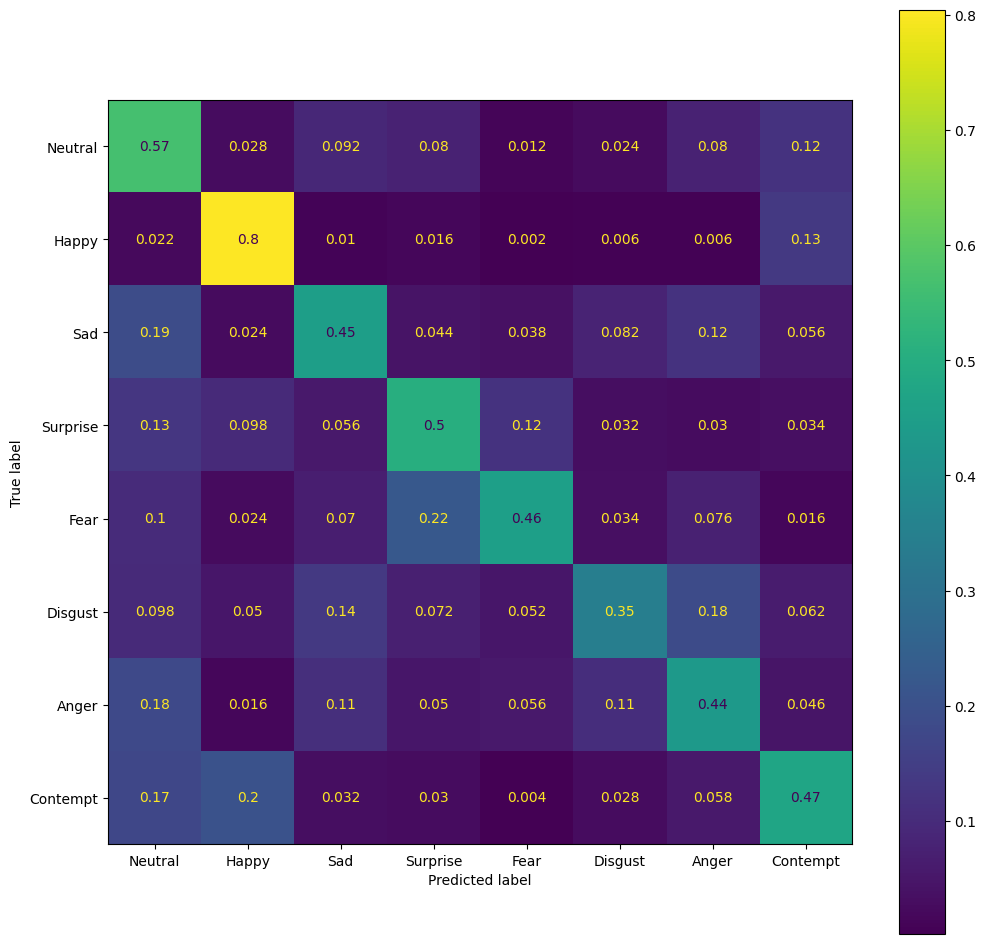

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)